In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import pickle
from settings import *

In [2]:
#TODO: resumen del proceso
#1 cargar todas diccionario con line index y sentence
#2 elminiar las mas largas de 50
#3 añadir las palabras al vocabulario
#4 eliminar las sentence con palabras que no salen
#5 pasar los pares con line index contiguos

In [3]:
# n_lines = 0
# with open(corpus, 'rb') as file:
#     for line in file:
#         n_lines += 1
# print(f'Numero de líneas: {n_lines}')

n_lines = 213_517_354
f"Lineas usadas sobre el total:{LINES_USED/n_lines:.3%}"

'Lineas usadas sobre el total:1.171%'

In [4]:
def printLines(stop=10, decode=False):
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            
            if decode:
                print(i,line.decode("utf-8"))
            else:
                print(i,line)
            if i==stop: break

printLines(10,False)

0 b'NETKonet trae para ti...\n'
1 b'"Twenty"\n'
2 b'[NEW Presenta]\n'
3 b'[Una producci\xc3\xb3n de A M Tree Pictures]\n'
4 b'[Sidus HQ]\n'
5 b'[Productor ejecutivo:\n'
6 b'Kim Woo Taek]\n'
7 b'Somos los t\xc3\xadpicos amigos de la secundaria que juraron que su amistad durar\xc3\xada para siempre.\n'
8 b'Aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros.\n'
9 b'Ejem... ejem.\n'
10 b'Ejem...\n'


In [5]:
#funcion para buscar ejemplos a la hora de tratar la puntuacion
def search_line(search_string,stop=10):
    n=0
    prev_line,line_found = "",""
    prnt = False
    
    with open(corpus, 'rb') as datafile:
        for i,line in enumerate(datafile):
            if prnt:
                print("-------------")
                print(prev_line.decode("utf-8"),line_found.decode("utf-8"),
                      line.decode("utf-8"), sep="\n")
                prnt = False
                n+=1
                if n==stop:
                    break
            if search_string in line: 
                line_found = line
                prnt = True
            else:
                prev_line = line
                
search_line(b":bi")

-------------
{F:

Times New Roman}{Y:bi}"Quien hace una bestia de sí mismo se libera del dolor de ser un hombre." DR.

JOHNSON

-------------
JOHNSON

{Y:bi}Estábamos cerca de Barstow, en el borde del desierto... {Y:bi}cuando las drogas comenzaron a tomar el control.

{y:bi}Recuerdo que dije algo como:

-------------
JOHNSON

{y:bi}Recuerdo que dije algo como:

Me siento un poco mareado.

-------------
Tal vez tú debieras manejar.

{Y:bi}De repente hubo un terrible estruendo alrededor nuestro... {Y:bi}y el cielo se llenó con lo que parecían murciélagos gigantes... {y:bi}revoloteando y chillando alrededor del auto.

{Y:bi}Y una voz gritó: ¡Santo Dios!

-------------
Tal vez tú debieras manejar.

{Y:bi}Y una voz gritó: ¡Santo Dios!

¡¿Qué son esos malditos animales?

-------------
Te toca manejar.

{Y:bi}No valía la pena mencionar a esos murciélagos, pensé.

{Y:bi}El pobre bastardo ya los vería pronto.

-------------
Te toca manejar.

{Y:bi}El pobre bastardo ya los vería pronto.

¡Maldi

In [6]:
#Procesado de la puntuación
def process_punct(s):
    s = s.strip().lower().decode()
    s = re.sub(r"\.000",r" mil", s)
    s = re.sub(r"^-",       r"<GUION_INIC>", s)
    s = re.sub(r"-{2}",     r"<GUION_DOBL>", s)
    s = re.sub(r"\.{3}",    r"<TRIP_DOT>", s)
    s = re.sub(r"{y:bi}",   r"<SPECIAL_1>", s)
    s = re.sub(r"(\w)-(\w)",r"\1<GUION_INTER>\2", s)
    s = re.sub(r"([\):!?])",r" \1", s)      #separa puntuacion con espacio antes
    s = re.sub(r"([\(¡¿])", r"\1 ", s)      #separa puntuacion con espacio despues
    s = re.sub(r"([\"-,¿\.}])", r" \1 ", s) #espacio antes y despues
    
    #separa los tokens
    s = re.sub(r"<", r" <", s)
    s = re.sub(r">", r"> ", s)
    
    s = re.sub(r"\s<GUION_INTER>\s",r"-", s)
    return s

print("#Test  0:", process_punct("-t. -t".encode()))
print("#Test  1:", process_punct("t. .t ¿t?".encode()))
print("#Test  2:", process_punct("t... ¿¿¿t???".encode()))
print("#Test  3:", process_punct("...t ...".encode()))
print("#Test  4:", process_punct("???...!!!".encode()))
print("#Test  5:", process_punct('"¿Cómo?"'.encode()))
print("#Test  6:", process_punct('(--8:)'.encode()))
print("#Test  7:", process_punct('electro-quimico'.encode()))
print("#Test  8:", process_punct('que--'.encode()))
print("#Test  9:", process_punct('-ivanov'.encode()))
print("#Test 10:", process_punct('10.000, 5:45'.encode()))
print("#Test 11:", process_punct('8:00 8:00h'.encode()))
print("#Test 12:", process_punct('.¿ -¿'.encode()))
print("#Test 13:", process_punct('{y:bi}vamos'.encode()))

#Test  0:  <GUION_INIC> t .  -t
#Test  1: t .   . t  ¿  t ?
#Test  2: t <TRIP_DOT>   ¿   ¿   ¿  t ? ? ?
#Test  3:  <TRIP_DOT> t  <TRIP_DOT> 
#Test  4:  ? ? ? <TRIP_DOT>  ! ! !
#Test  5:  "  ¿  cómo ? " 
#Test  6:  (   <GUION_DOBL> 8 :  ) 
#Test  7: electro-quimico
#Test  8: que <GUION_DOBL> 
#Test  9:  <GUION_INIC> ivanov
#Test 10: 10 mil ,  5 :45
#Test 11: 8 :00 8 :00h
#Test 12:  .  ¿   - ¿  
#Test 13:  <SPECIAL_1> vamos


In [ ]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [7]:
def loadLines(file, total_lines=10, max_lenght=MAX_LENGTH):
    with open(file, 'rb') as datafile:
        n=0
        for i,line in enumerate(datafile):
            if max(line.find(b"["),line.find(b"]")) == -1: #filtra los comentarios
                s = process_punct(line)
                s = s.strip().split()
                if len(s) < max_lenght: #filtra frases largas
                    n+=1
                    yield i,s
            if n==total_lines: break
                
for i,l in loadLines(corpus,10): print(i,l)

0 ['netkonet', 'trae', 'para', 'ti', '<TRIP_DOT>']
1 ['"', 'twenty', '"']
7 ['somos', 'los', 'típicos', 'amigos', 'de', 'la', 'secundaria', 'que', 'juraron', 'que', 'su', 'amistad', 'duraría', 'para', 'siempre', '.']
8 ['aunque', 'las', 'circunstancias', 'del', 'inicio', 'de', 'nuestra', 'amistad', 'no', 'fueron', 'especiales', 'en', 'cierto', 'modo', 'fueron', 'especiales', 'para', 'nosotros', '.']
9 ['ejem', '<TRIP_DOT>', 'ejem', '.']
10 ['ejem', '<TRIP_DOT>']
12 ['<GUION_INIC>', '¿', 'le', 'acariciaste', 'el', 'pecho', 'a', 'fo', 'min', '?']
13 ['<GUION_INIC>', 'no', '.']
14 ['no', 'se', 'lo', 'acaricié', ',', 'me', 'quede', 'allí', 'parado', 'tocándolo', '.']
15 ['<GUION_INIC>', 'debes', 'estar', 'demente', '.']


In [8]:
# Default word tokens
class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, spl_sent):
        for word in spl_sent:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print(f"keep_words {len(keep_words)} / { len(self.word2index)} = "
              f"{len(keep_words) / len(self.word2index):.4f}")

        # Reinitialize dictionaries
        self.word2index = {"UNK": UNK_token}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS", UNK_token:"UNK"}
        self.num_words = 4 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Número de palabras: 128077


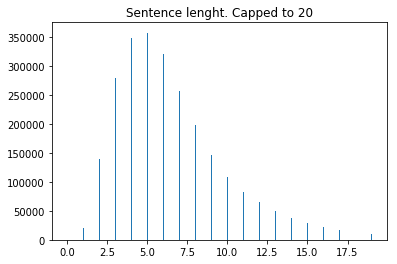

CPU times: user 2min 6s, sys: 1.17 s, total: 2min 7s
Wall time: 2min 8s


In [9]:
%%time
#TODO: multicpu
voc = Voc(corpus_name)

hist = []  
for i,s in loadLines(corpus,LINES_USED):
    s_l = len(s)
    hist.append(s_l)
    voc.addSentence(s)
    
print(f'Número de palabras: {voc.num_words}')

arr = np.array(hist)
plt.hist(arr, bins='auto')  # arguments are passed to np.histogram
plt.title(f"Sentence lenght. Capped to {MAX_LENGTH}")
plt.show()

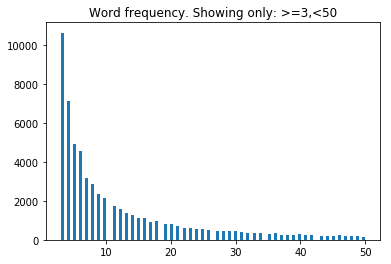

In [10]:
hist=[]
for i,n in enumerate(voc.word2count):
    c = voc.word2count[n]
    if c>=3:
        hist.append(c)
        
arr = np.array(hist)
plt.hist(arr, bins=100,range=(3,50))  # arguments are passed to np.histogram
plt.title(f"Word frequency. Showing only: >=3,<50")
plt.show()

In [11]:
from collections import Counter
c = Counter(voc.word2count)
c.most_common()

[('.', 1680776),
 (',', 653863),
 ('?', 465639),
 ('¿', 431659),
 ('<GUION_INIC>', 392378),
 ('no', 373699),
 ('que', 362942),
 ('de', 359201),
 ('a', 269825),
 ('la', 247758),
 ('!', 246742),
 ('el', 211742),
 ('¡', 209894),
 ('es', 198738),
 ('y', 174708),
 ('en', 169289),
 ('lo', 166683),
 ('un', 163037),
 ('<TRIP_DOT>', 139730),
 ('qué', 136089),
 ('me', 126750),
 ('por', 122937),
 ('una', 103434),
 ('te', 96300),
 ('se', 91965),
 ('los', 82466),
 ('con', 79677),
 ('para', 71973),
 ('está', 71642),
 ('"', 70477),
 ('si', 67130),
 ('mi', 65812),
 ('pero', 65264),
 ('sí', 64781),
 ('yo', 60143),
 ('eso', 56697),
 ('bien', 55029),
 ('las', 54950),
 ('su', 53584),
 ('le', 48641),
 ('aquí', 47131),
 ('al', 46512),
 ('más', 42956),
 ('del', 42474),
 ('como', 41970),
 ('tu', 41575),
 ('ya', 38667),
 ('todo', 35776),
 ('esto', 34495),
 ('ha', 32910),
 ('muy', 32342),
 ('vamos', 30878),
 ('hay', 30502),
 ('ahora', 30421),
 ('nada', 29357),
 ('esta', 29296),
 ('algo', 28818),
 ('estoy', 2847

In [12]:
#Check de la puntuacion
punt_dict = {}
for word in c:
    for punt in ",.¿?¡!\":()-{}":
        if punt in word:
            if len(word)>1 and c[word]>3:
                punt_dict[word] = c[word]
c2 = Counter(punt_dict)
c2.most_common()

[(':00', 1147),
 (':30', 555),
 (':15', 134),
 ('brogan-moore', 104),
 (':10', 100),
 ('-¡', 97),
 ('jean-luc', 95),
 ('sg-1', 92),
 (':45', 89),
 ('rau-ru', 88),
 ('mm-hmm', 86),
 (':25', 71),
 ('yo-yo', 67),
 ('g-14', 62),
 ('coca-cola', 59),
 ('e-mail', 59),
 ('wada-san', 56),
 ('ujiie-san', 56),
 (':22', 52),
 ('pah-wraiths', 52),
 ('uh-huh', 51),
 (':26', 49),
 (':55', 49),
 (':40', 44),
 ('jin-a', 44),
 (':50', 43),
 (':05', 42),
 ('bate-huevos', 42),
 ('hana-ogi', 42),
 (':18', 42),
 ('anne-claire', 39),
 ('que-', 39),
 ('x-71', 36),
 ('15h-32', 36),
 ('jean-bat', 36),
 ('shen-san', 36),
 ('in-n-out', 35),
 (':58', 34),
 ('slug-o-cola', 33),
 ('b-4', 33),
 ('1-5', 32),
 ('q-qué', 32),
 ('20-40', 32),
 ('si-chang', 32),
 (':43', 31),
 ('loh-mann', 30),
 ('auto-mac', 30),
 ('y-', 29),
 ('hombre-lobo', 29),
 ('sg-3', 29),
 ('ex-mujer', 29),
 ('ex-esposa', 28),
 ('lancet-percy', 28),
 ('malk-shur', 27),
 (':06', 27),
 (':32', 26),
 ('32-58-78', 26),
 (':07', 26),
 ('expedientes-x', 

In [14]:
voc.trim(MIN_COUNT)

keep_words 37297 / 128075 = 0.2912


In [15]:
def has_trimmed_or_unk(spl_snt):
    """ Filter out sentences with trimmed words or words not in the voc
    spl_snt is a list of words"""
    for word in spl_snt:
        if word not in voc.word2index:
            return True

In [17]:
trm_unk = 0
for i,s in loadLines(corpus,LINES_USED):
    if has_trimmed_or_unk(s): trm_unk +=1
        
full_pairs =  LINES_USED - trm_unk      

print(f"From {LINES_USED} pairs, {full_pairs} does not contain trimmed or unkonwn words,", 
      f"{full_pairs / LINES_USED:.4f} of total")

From 2500000 pairs, 2278725 does not contain trimmed or unkonwn words, 0.9115 of total


In [18]:
#aumentando min_count de 3 a 5 el vocabulario pasa de 72510(57%) a 36642(29%), sin embargo las frases aceptadas 
#solo baja un 6%, de 97.33% a 91.27%, o lo que es más impactante, con un tercio del vocabulario total podemos 
#recrear más del 90% del dataset , TODO restestear con diferentes min count cuando este el multicpu

In [19]:
# spl_snt is a list of words
def indexesFromSentence(spl_snt, voc):
    idxs = []
    for word in spl_snt:
        try:
            idxs += [voc.word2index[word]]
        except:
            idxs += [UNK_token] #word2index["UNK"]=UNK_token
    return idxs + [EOS_token]

def gen_pairs(how_many, voc):
    first_inp = True
    n=0
    for out_idx, out_snt in loadLines(corpus,LINES_USED):
        
        if first_inp: #first cycle, set first input
            inp_idx, inp_snt = out_idx, out_snt
            first_inp = False
            continue

        if inp_idx+1 == out_idx: #frases contiguas (loadLines filter long sentences)
            ok_inp = True if WITH_UNK else not has_trimmed_or_unk(inp_snt) # if WITH_UNK==True, every inp is accepted
            ok_out = not has_trimmed_or_unk(out_snt)
            
            if ok_inp and ok_out: #every word is in Voc
                n+=1
                yield [indexesFromSentence(inp_snt, voc),indexesFromSentence(out_snt, voc)]
        
        if n==how_many:break
        inp_idx, inp_snt = out_idx, out_snt #prepare next cycle
        
for pair in gen_pairs(10,voc): print(pair)

[[9, 10, 11, 12, 13, 14, 15, 16, 3, 16, 17, 18, 19, 5, 20, 21, 2], [22, 23, 24, 25, 26, 13, 27, 18, 28, 29, 30, 31, 32, 33, 29, 30, 5, 34, 21, 2]]
[[22, 23, 24, 25, 26, 13, 27, 18, 28, 29, 30, 31, 32, 33, 29, 30, 5, 34, 21, 2], [35, 7, 35, 21, 2]]
[[35, 7, 35, 21, 2], [35, 7, 2]]
[[36, 37, 38, 3, 39, 40, 41, 3, 42, 43, 2], [36, 28, 21, 2]]
[[28, 44, 45, 3, 46, 47, 48, 49, 50, 3, 21, 2], [36, 51, 52, 53, 21, 2]]
[[36, 51, 52, 53, 21, 2], [36, 37, 54, 55, 56, 57, 43, 2]]
[[36, 37, 54, 55, 56, 57, 43, 2], [37, 58, 16, 59, 56, 57, 46, 60, 43, 2]]
[[37, 58, 16, 59, 56, 57, 46, 60, 43, 2], [61, 46, 16, 62, 28, 9, 63, 21, 2]]
[[61, 46, 16, 62, 28, 9, 63, 21, 2], [37, 31, 64, 65, 66, 5, 67, 68, 69, 56, 70, 43, 2]]
[[37, 31, 64, 65, 66, 5, 67, 68, 69, 56, 70, 43, 2], [71, 72, 13, 73, 74, 21, 2]]


In [20]:
for pair in gen_pairs(10,voc): 
    for i in pair:
        snt = []
        for idx in i:
            snt += [voc.index2word[idx]]
        print(*snt)
    print("---")

somos los típicos amigos de la secundaria que UNK que su amistad duraría para siempre . EOS
aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros . EOS
---
aunque las circunstancias del inicio de nuestra amistad no fueron especiales en cierto modo fueron especiales para nosotros . EOS
ejem <TRIP_DOT> ejem . EOS
---
ejem <TRIP_DOT> ejem . EOS
ejem <TRIP_DOT> EOS
---
<GUION_INIC> ¿ le UNK el pecho a UNK min ? EOS
<GUION_INIC> no . EOS
---
no se lo UNK , me quede allí parado UNK . EOS
<GUION_INIC> debes estar demente . EOS
---
<GUION_INIC> debes estar demente . EOS
<GUION_INIC> ¿ eso es una pregunta ? EOS
---
<GUION_INIC> ¿ eso es una pregunta ? EOS
¿ crees que fue una pregunta , idiota ? EOS
---
¿ crees que fue una pregunta , idiota ? EOS
ey , que ya no somos niños . EOS
---
ey , que ya no somos niños . EOS
¿ en qué estaban pensando para pelear así por una chica ? EOS
---
¿ en qué estaban pensando para pelear así por u

In [21]:
pairs = list(gen_pairs(LINES_USED,voc))

In [22]:
"""
se obtienen menos pares que lineas usadas, con lineas usadas se crea el diccionario, con ese diccionario elegimos 
las palabras con las que quedarnos, se descartan las lineas con palabras borradas y de ahi solo cogemos los pares
de lineas contiguos
"""
len(pairs)

2242399

In [23]:
#Guardar pairs y voc
with open(save_dir + '/pairs.pkl', 'wb') as file:
    pickle.dump(pairs, file)

with open(save_dir + '/voc.pkl', 'wb') as file:
    voc.__module__ = "Voc"
    pickle.dump(voc, file)

In [ ]:
# # Example for validation
# small_batch_size = 6
# pairs_list = [random.choice(pairs) for _ in range(small_batch_size)]
# batches = batch2TrainData(pairs_list)
# input_variable, lengths, target_variable, mask, max_target_len = batches

# print("input_variable:\n", input_variable)
# print("lengths:", lengths)
# print("target_variable:\n", target_variable)
# print("mask:\n", mask)
# print("max_target_len:", max_target_len)